In [1]:
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

from statsmodels.stats.proportion import proportions_ztest

In [2]:
alpha = 0.005

## Read Data

In [3]:
jobs_df = pd.read_csv("Joblistings.csv")
jobs_df = jobs_df.rename(columns={'Research': 'Research Scientist'})
jobs_df.head(3)

,Company Name,Job Title,Location,Industry,Job Description,Business Analyst,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer,...,BIToolUsed_Domo,BIToolUsed_TIBCO Spotfire,BIToolUsed_Alteryx,BIToolUsed_Sisense,BIToolUsed_SAP Analytics Cloud,BIToolUsed_Microsoft Azure Synapse,BIToolUsed_Thoughtspot,BIToolUsed_Salesforce,BIToolUsed_Tableau CRM,BIToolUsed_Qlik
0,80 Acres Farms,SENIOR COMPUTER VISION DATA SCIENTIST,"Hamilton, OH",Farming,About The Company\r\n\r\nThe Future of Fresh i...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Terran Robotics,Senior Software Engineer,"Bloomington, IN",None,Terran Robotics is building construction robot...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ZF Group,Systems Engineer,Greater Lansing,Motor Vehicle Manufacturing,Job description \r\n\r\nJob Description \r\n\r...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
skills_df = pd.concat([pd.read_csv(
    "./Kaggle-Data-Science-ML-Survey-Analysis/data/processed/ProcessedSurveyData_%d.csv" % i) 
                       for i in range(2020,2023)])
skills_df.head(3)

,Unnamed: 0,Unnamed: 0.1,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,1,NaN,1838,35-39,Man,Colombia,Yes,1,0,1,...,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,289287,30-34,Man,United States of America,No,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,860,35-39,Man,Argentina,No,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [5]:
with open("./Kaggle-Data-Science-ML-Survey-Analysis/data/raw/ds_survey/survey_cols.json", 'r') as f:
    survey_cols = json.load(f)

[col for col in survey_cols if 'MLFramework_' in col][:5]

['MLFramework_Scikit-learn',
 'MLFramework_TensorFlow',
 'MLFramework_Keras',
 'MLFramework_PyTorch',
 'MLFramework_Fast.ai']

# Is there a mismatch between job listings and employee skills?

In [6]:
job_families = ['Business Analyst', 'Data Analyst', 'Data Engineer', 'Data Scientist',
               'Machine Learning Engineer', 'Research Scientist']

In [7]:
# Since we have job data for data science roles in the United States, we filter individuals from US.
skills_df_us = skills_df[(skills_df['Country'] == "United States of America") & 
                      (skills_df["CurrentTitle"].isin(job_families))]

survey_cnts = skills_df_us['CurrentTitle'].value_counts().sort_index()  # Survey Data
survey_cnts = survey_cnts.rename("# Survey Responses").to_frame()  # Jobs Data

job_cnts = jobs_df[job_families].sum().sort_index()
job_cnts = job_cnts.rename("# Job Listings").to_frame()

cnts = survey_cnts.join(job_cnts)
cnts

,# Survey Responses,# Job Listings
Business Analyst,216,2726
Data Analyst,450,6638
Data Engineer,210,2371
Data Scientist,1184,1102
Machine Learning Engineer,203,594
Research Scientist,438,391


### Exp: Data Scientist skill gaps

In [8]:
# Proportion of Data Scientists who regularly use SQL
ds = skills_df_us[skills_df_us['CurrentTitle'] == "Data Scientist"]
round(ds['ProgLanguage_SQL'].sum()/len(ds), 2)

0.72

In [9]:
# Proportion of Data Scientist jobs which require SQL
ds_jobs = jobs_df[jobs_df["Data Scientist"]==1]
round(ds_jobs['ProgLanguage_SQL'].sum()/len(ds_jobs), 2)

0.61

### Z-Test for Proportions (1-tailed)

$H0: p_1 - p_2 > 0 $ </br>
$H1: p_1 - p_2 \leq 0 $ </br></br>
Test statistic $$ z = \frac{\hat{p}_1 - \hat{p}_2}{\hat{p}(1-\hat{p}) \big(\frac{1}{n_1} + \frac{1}{n_2}\big)}, \quad\quad \hat{p} = \frac{x_1 + x_2}{n_1 + n_2}$$


### Assumptions:
1. The two populations are approximately normal.
2. The two proportions are independent.

In [10]:
count = np.array([ds['ProgLanguage_SQL'].sum(), ds_jobs['ProgLanguage_SQL'].sum()])
nobs = np.array([len(ds), len(ds_jobs)])
stat, pval = proportions_ztest(count, nobs, alternative="smaller")
pval # In fact, more data scientists know SQL than required by jobs!

0.9999999897156079

# Do not blindly believe the JD - Apply anyway!
Is there a mismatch between the required skills for a job and what is listed on the JDs?

In [11]:
skillsets = ["ProgLanguage_",
             "MLFramework_",
             "MLAlgo_",
             "VizLib_",
             "CloudProviderUsed_",
             "DBUsed_",
             "BIToolUsed_"
            ]

for job_family in job_families:
    print(job_family)
    
    for skillset in skillsets:
        skill_cols = [col for col in survey_cols if skillset in col and "None" not in col and
                     "Other" not in col] # Exp: all Programming Languages
        for skill in skill_cols:
            ds_resps = skills_df_us[skills_df_us['CurrentTitle'] == job_family] # Exp, Data Scientist responses
            ds_jobs = jobs_df[jobs_df[job_family]==1] # Exp, Data Scientist jobs

            # Z-Test for Proportions
            count = np.array([ds_resps[skill].sum(), ds_jobs[skill].sum()])
            nobs = np.array([len(ds_resps), len(ds_jobs)])
            stat, pval = proportions_ztest(count, nobs, alternative="smaller") # Resp p < JD p

            if pval < alpha:
                p_resps = round(ds_resps[skill].sum()/len(ds_resps), 2)
                p_jobs = round(ds_jobs[skill].sum()/len(ds_jobs), 2)
                print(f"""{skill}: {p_resps} Respondents, {p_jobs} Jobs""")
                
    print("\n")

Business Analyst
ProgLanguage_Go: 0.0 Respondents, 0.06 Jobs


Data Analyst
ProgLanguage_C: 0.02 Respondents, 0.06 Jobs
ProgLanguage_Java: 0.04 Respondents, 0.12 Jobs
ProgLanguage_Go: 0.0 Respondents, 0.05 Jobs


Data Engineer
ProgLanguage_Java: 0.19 Respondents, 0.43 Jobs
ProgLanguage_Go: 0.0 Respondents, 0.06 Jobs


Data Scientist
ProgLanguage_R: 0.43 Respondents, 0.55 Jobs
ProgLanguage_C: 0.04 Respondents, 0.19 Jobs
ProgLanguage_Java: 0.07 Respondents, 0.24 Jobs
ProgLanguage_Go: 0.0 Respondents, 0.07 Jobs
MLFramework_MXNet: 0.01 Respondents, 0.03 Jobs


Machine Learning Engineer
ProgLanguage_C: 0.1 Respondents, 0.33 Jobs
ProgLanguage_Java: 0.22 Respondents, 0.38 Jobs
ProgLanguage_PHP: 0.0 Respondents, 0.05 Jobs
ProgLanguage_Go: 0.0 Respondents, 0.07 Jobs


Research Scientist
ProgLanguage_C: 0.15 Respondents, 0.29 Jobs




## Interesting Findings:
1. Only 20% Data Engineers reported using Java on the job, however, it is listed as a requirement in over 40% job descriptions.
2. C Language is oversold for Research Scientists, MLEs, and Data Scientists.
3. Odd languages such as Go and PHP are sometimes listed on Data science JDs, but rarely used in practice.
4. 43% Data Scientists reported programming regularly in R. This is close to, but significantly lower than 55% jobs which list it as a requirement.

# Latent skills you didn't know you need to learn!
Skills that are not advertised on the JDs but frequently used in practice.

In [12]:
res = []

for job_family in job_families:    
    for skillset in skillsets:
        skill_cols = [col for col in survey_cols if skillset in col and "None" not in col and
                     "Other" not in col] # Exp: all Programming Languages
        for skill in skill_cols:
            ds_resps = skills_df_us[skills_df_us['CurrentTitle'] == job_family] # Exp, Data Scientist responses
            ds_jobs = jobs_df[jobs_df[job_family]==1] # Exp, Data Scientist jobs

            # Z-Test for Proportions
            count = np.array([ds_resps[skill].sum(), ds_jobs[skill].sum()])
            nobs = np.array([len(ds_resps), len(ds_jobs)])
            stat, pval = proportions_ztest(count, nobs, alternative="larger") # Resp p > JD p

            if pval < alpha:
                p_resps = round(ds_resps[skill].sum()/len(ds_resps), 2)
                p_jobs = round(ds_jobs[skill].sum()/len(ds_jobs), 2)
                res.append([job_family, skill, p_resps, p_jobs])

res = pd.DataFrame(res, columns=['Job Title', 'Skill', 'p_Respondents', 'p_Jobs'])
res['Diff'] = res['p_Respondents'] - res['p_Jobs']
res = res.sort_values(by=['Job Title', 'Diff'], ascending=[True, False]).reset_index(drop=True)
res.head(3)

,Job Title,Skill,p_Respondents,p_Jobs,Diff
0,Business Analyst,ProgLanguage_Python,0.63,0.09,0.54
1,Business Analyst,VizLib_Matplotlib,0.47,0.00,0.47
2,Business Analyst,MLAlgo_Linear or Logistic Regression,0.46,0.02,0.44


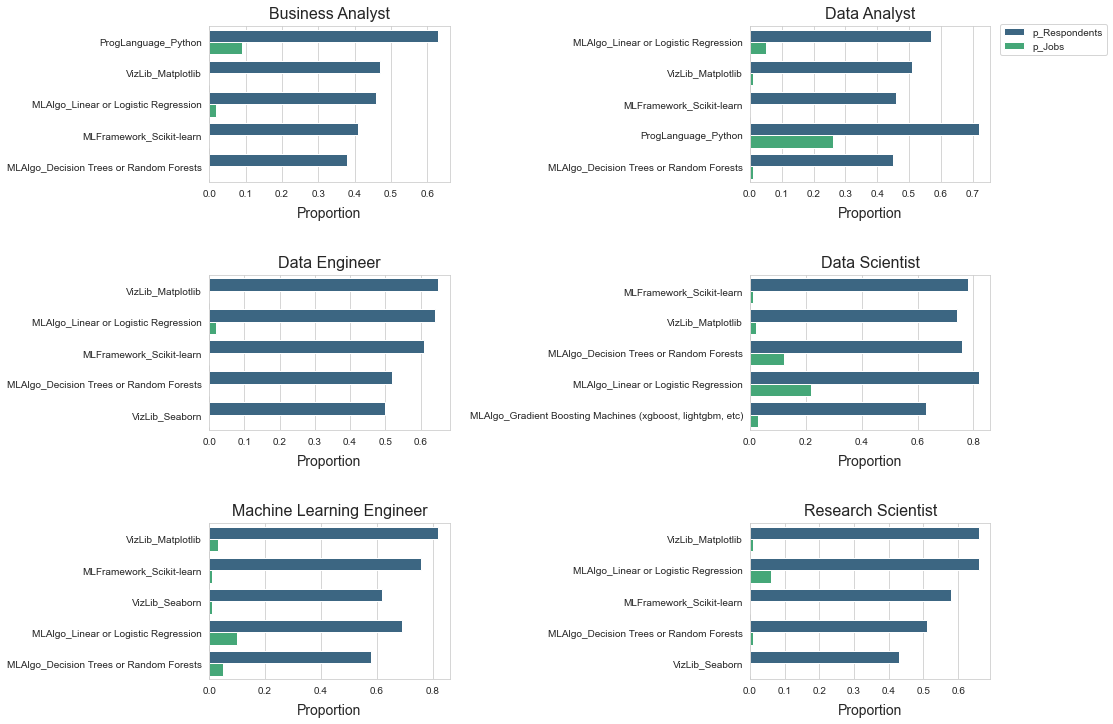

In [13]:
# Top skills for each Job (not listed on the JD)
fig, axs = plt.subplots(3,2, figsize=(14,12), gridspec_kw={'wspace':1.25, 'hspace':0.6})
row, col = 0, 0

for job_family in job_families:

    s = res[res['Job Title'] == job_family].head(5)
    s = s.melt(id_vars=['Job Title', 'Skill'], value_vars=['p_Respondents', 'p_Jobs'], value_name='p')
    
    if(col == 2):
        row += 1
        col = 0
    
    ax = axs[row][col]
    sns.barplot(y=s['Skill'], x=s['p'], hue=s['variable'], ax=ax, palette='viridis')
    ax.set_title(job_family, fontsize=16, pad=8)
    ax.set_xlabel("Proportion", fontsize=14, labelpad=8)
    ax.set_ylabel("", fontsize=14, labelpad=8)
    if not (row == 0 and col == 1):
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1.02, 1.05))
    col += 1
    
    
plt.show()

In [14]:
res[(res['Job Title'] == 'Data Scientist') & (res['Diff']>0.5)]

,Job Title,Skill,p_Respondents,p_Jobs,Diff
241,Data Scientist,MLFramework_Scikit-learn,0.78,0.01,0.77
242,Data Scientist,VizLib_Matplotlib,0.74,0.02,0.72
243,Data Scientist,MLAlgo_Decision Trees or Random Forests,0.76,0.12,0.64
244,Data Scientist,MLAlgo_Linear or Logistic Regression,0.82,0.22,0.60
245,Data Scientist,"MLAlgo_Gradient Boosting Machines (xgboost, li...",0.63,0.03,0.60
246,Data Scientist,VizLib_Seaborn,0.61,0.01,0.60


## Interesting Findings:
1. Business Analysts should have knowledge of Python and visualization tools.
2. Many Data Analysts and Data Engineers are using ML in their day to day work.
3. Sklearn is underrated. Commonly used ML models inlude: Tree-based methods, Linear & Logistic Regression, Gradient boosting machines.
4. Although not specified on the JDs, MLEs should be good with Bash.

# Our Tips to get hired!

### Top Skills (overall) for Data Science jobs

In [15]:
cnts = jobs_df.iloc[:,11:].sum()
cnts = cnts/len(jobs_df)

# Overall Ranking
cnts.sort_values(ascending=False)[:5]

ProgLanguage_SQL                               0.495734
ProgLanguage_Python                            0.339762
CloudProviderUsed_Amazon Web Services (AWS)    0.197188
ProgLanguage_Java                              0.178863
BIToolUsed_Tableau                             0.172314
dtype: float64

In [16]:
# SQL is your best friend. It is good to skill yourself in AWS.

### Top Programming Languages

In [17]:
cnts[cnts.index.str.contains("ProgLanguage")].sort_values(ascending=False)[:5]

ProgLanguage_SQL       0.495734
ProgLanguage_Python    0.339762
ProgLanguage_Java      0.178863
ProgLanguage_R         0.167207
ProgLanguage_C         0.110190
dtype: float64

In [18]:
# In our dataset, Java is almost as common as R.

### Top ML algorithms to add to your resume

In [19]:
cnts[cnts.index.str.contains("MLAlgo")].sort_values(ascending=False)[:10]

MLAlgo_Linear or Logistic Regression                          0.048065
MLAlgo_Convolutional Neural Networks                          0.017664
MLAlgo_Decision Trees or Random Forests                       0.015081
MLAlgo_Transformer Networks (BERT, gpt-3, etc)                0.009853
MLAlgo_Bayesian Approaches                                    0.008892
MLAlgo_Gradient Boosting Machines (xgboost, lightgbm, etc)    0.005407
MLAlgo_Recurrent Neural Networks                              0.004807
MLAlgo_Dense Neural Networks (MLPs, etc)                      0.001742
MLAlgo_Autoencoder Networks (DAE, VAE, etc)                   0.000901
MLAlgo_Generative Adversarial Networks                        0.000601
dtype: float64

### Top Cloud tools used in the industry

In [20]:
cnts[cnts.index.str.contains("CloudProviderUsed")].sort_values(ascending=False)[:5]

CloudProviderUsed_Amazon Web Services (AWS)      0.197188
CloudProviderUsed_Microsoft Azure                0.066090
CloudProviderUsed_Google Cloud Platform (GCP)    0.040014
CloudProviderUsed_IBM Cloud / Red Hat            0.003064
CloudProviderUsed_Oracle Cloud                   0.000841
dtype: float64

In [21]:
# AWS > Azure > GCP

### Top Databases you should skill yourself in

In [22]:
cnts[cnts.index.str.contains("DBUsed")].sort_values(ascending=False)[:5]

DBUsed_Amazon Redshift    0.037731
DBUsed_MySQL              0.034126
DBUsed_Snowflake          0.030882
DBUsed_MongoDB            0.022290
DBUsed_PostgreSQL         0.017664
dtype: float64

### Top Viz tools

In [23]:
cnts[cnts.index.str.contains("VizLib")].sort_values(ascending=False)[:5]

VizLib_D3 js               0.007991
VizLib_Matplotlib          0.005648
VizLib_Shiny               0.004206
VizLib_Ggplot / ggplot2    0.003965
VizLib_Seaborn             0.002223
dtype: float64